<a href="https://colab.research.google.com/github/Nick-FF/Py_Libra_Ext/blob/Kursovoy/class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import seaborn as sns
%matplotlib inline

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_full = pd.read_csv('/train.csv', sep=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_full

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [ ]:
df_full.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # if str(col_type)[:3] == 'flo'and (c_min *10)%10 == 0 and (c_max *10)%10 == 0:
            #   df[col] = df[col].astype(np.int64)

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
train_df = reduce_mem_usage(df_full)
train_df.head()

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [ ]:
df_full.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                      int8
dtype: object

#Обзор данных#
Обзор целевой переменной

In [ ]:
df_full['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Обзор количественных признаков

In [ ]:
df_full.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


Обзор номинативных признаков

In [ ]:
for cat_colname in df_full.select_dtypes(include='category').columns:
    print(str(cat_colname) + '\n\n' + str(df_full[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Обработка пропусков

In [ ]:
len(df_full) - df_full.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [ ]:
df_full.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [ ]:
# df_full.fillna(self.mode()[0], inplace=True)
# df_full.loc[df_full['Annual Income'] == 'NaN', 'Annual Income'] = df_full['Annual Income'].mode()[0]
# df_full.loc[df_full['Tax Liens'] == '0', 'Tax Liens'] = df_full['Tax Liens'].mode()[0]
# df_full['Annual Income'].isna() = df_full['Annual Income'].mean()
# df_full['Annual Income'].isna()
# df_full['Annual Income'].mode()[0]
# df_full.loc[df_full['Years in current job'] == 'NaN', 'Years in current job'] = df_full['Years in current job'].mode()[0]
# df_full.loc[df_full['Months since last delinquent'] == 'NaN', 'Months since last delinquent'] = df_full['Months since last delinquent'].mode()[0]
# df_full.loc[df_full['Credit Score'] == 'NaN', 'Credit Score'] = df_full['Credit Score'].mode()[0]
df_full.fillna(df_full.mean())

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,NaN,0.0,11.0,26.299999,685960.0,1.0,34.6926,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.000000,0
1,Own Home,1025487.00,10+ years,0.0,15.0,15.300000,1181730.0,0.0,34.6926,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.000000,1
2,Home Mortgage,751412.00,8 years,0.0,11.0,35.000000,1182434.0,0.0,34.6926,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.000000,0
3,Own Home,805068.00,6 years,0.0,8.0,22.500000,147400.0,1.0,34.6926,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.000000,0
4,Rent,776264.00,8 years,0.0,13.0,13.600000,385836.0,1.0,34.6926,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.00,< 1 year,0.0,3.0,8.500000,107866.0,0.0,34.6926,0.0,other,Short Term,129360.0,73492.0,1900.0,697.000000,0
7496,Home Mortgage,1533984.00,1 year,0.0,10.0,26.500000,686312.0,0.0,43.0000,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.000000,1
7497,Rent,1878910.00,6 years,0.0,12.0,32.099998,1778920.0,0.0,34.6926,0.0,buy a car,Short Term,100000000.0,477812.0,12479.0,748.000000,0
7498,Home Mortgage,1366389.75,NaN,0.0,21.0,26.500000,1141250.0,0.0,34.6926,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,1151.087524,0


In [ ]:
df_full

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.500000,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.500000,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.099998,1778920.0,0.0,NaN,0.0,buy a car,Short Term,100000000.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.500000,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


**Выделение целевой переменной и групп признаков**

In [ ]:
TARGET_NAME = 'Credit Default'

BASE_FEATURE_NAMES = df_full.columns.drop(TARGET_NAME).tolist()
BASE_FEATURE_NAMES = df_full.columns.drop('Years in current job').tolist()

NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership',  'Purpose', 'Term']


In [ ]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

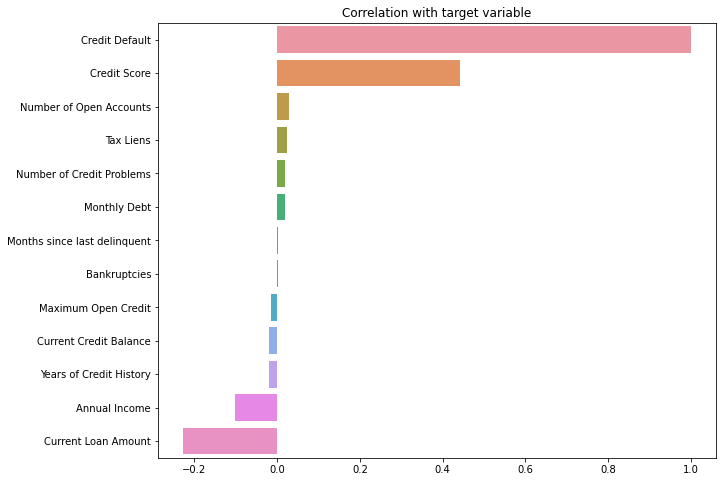

In [ ]:
corr_with_target = df_full[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Подготовка для catboost


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [ ]:
import catboost as catb
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [ ]:
X = df_full[BASE_FEATURE_NAMES]
y = df_full[TARGET_NAME]


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [ ]:
X_train

,Home Ownership,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5636,Home Mortgage,2331528.0,0.0,15.0,49.099998,710050.0,0.0,NaN,0.0,home improvements,Short Term,562430.0,193173.0,26813.0,749.0,0
3283,Rent,NaN,0.0,14.0,20.000000,1163008.0,0.0,NaN,0.0,debt consolidation,Short Term,735152.0,633783.0,21002.0,NaN,0
3285,Home Mortgage,1316567.0,0.0,17.0,14.500000,307252.0,0.0,13.0,0.0,business loan,Long Term,261338.0,135318.0,28087.0,659.0,0
3712,Home Mortgage,NaN,0.0,16.0,16.700001,975414.0,0.0,32.0,0.0,medical bills,Short Term,135146.0,788481.0,26319.0,NaN,1
2391,Rent,965295.0,0.0,5.0,13.300000,373406.0,1.0,NaN,1.0,debt consolidation,Short Term,223542.0,122227.0,15525.0,744.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,Rent,657286.0,0.0,6.0,8.400000,100056.0,0.0,NaN,0.0,debt consolidation,Short Term,208758.0,66614.0,8764.0,740.0,0
172,Rent,1197323.0,0.0,17.0,12.000000,671176.0,0.0,NaN,0.0,debt consolidation,Short Term,290686.0,213902.0,17660.0,748.0,0
327,Rent,1465337.0,0.0,9.0,17.700001,125642.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,62168.0,21248.0,747.0,0
4459,Rent,1405164.0,0.0,14.0,11.800000,356598.0,0.0,NaN,0.0,debt consolidation,Long Term,445764.0,292258.0,27050.0,699.0,0


In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [ ]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, 
                                     cat_features=CAT_FEATURE_NAMES,
#                                      one_hot_max_size=6
                                     )
model_catb.fit(X_train, y_train, plot=True)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      1479

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1616
           1       1.00      1.00      1.00       634

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1616    0
1                  0  634


In [ ]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [ ]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [ ]:
model_catb1 = catb.CatBoostClassifier(**frozen_params, iterations=500, max_depth=7)
model_catb1.fit(X_train, y_train, plot=True , eval_set=(X_test, y_test))
evaluate_preds(model_catb1, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      1479

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1616
           1       1.00      1.00      1.00       634

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1616    0
1                  0  634


In [ ]:
submit = pd.read_csv('/sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [ ]:
submit['Credit Default'] = y_test
submit

,Id,Credit Default
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
...,...,...
2495,2495,1.0
2496,2496,NaN
2497,2497,NaN
2498,2498,0.0


In [ ]:
submit.to_csv('submit_sample.csv', index=False)